### Initialize the generator and produce synthetic samples (approximate runtime: 30 seconds)

In [1]:
from curses import raw
import random
import sys
import os
import pandas as pd
import numpy as np

# Add the project root directory to the Python module search path
sys.path.append(os.path.abspath(".."))

random_seed = 42
np.random.seed(random_seed)

In [2]:
try:
    data = pd.read_csv("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/time_series_generator/modified_data/resample_data.csv")
except:
    data = pd.read_csv("/home/gary/git_repo/jhern/V2B_Optimization_with_AI_on_BSS/time_series_generator/time_series_generator/modified_data/resample_data.csv")

data = data["raw_data"].tolist()

data = np.array(data)
data = data[~np.isnan(data)]

In [3]:
sample_seed = [35.0, np.nan, 35.0, np.nan, 35.0, 24.6, 27.0, 28.0, 23.0, 23.0, 23.666666666666668, 19.0, 27.0, 27.0, 37.0, 30.0, 27.0, 23.0, 25.666666666666668, 30.0, np.nan, 33.0, 34.0, np.nan, np.nan, np.nan, 22.5, 17.5, np.nan, 19.0, 25.0, np.nan, 25.0, 25.0, 25.5, 27.0]

In [ ]:
from time_series_generator.core import Generator as BlockGenerator
from time_series_generator.preprocessing import DataPrepare
import config as cfg

dataprep = DataPrepare(
    window_size=36,
    resolution=cfg.RESOLUTION,
    tolerance=1
)

# 新的呼叫方式
generator_random = BlockGenerator(
    seed=sample_seed,          
    datapreparer=dataprep,     
    window_size=36,
    max_shift=cfg.MAX_SHIFT,
    top_k=cfg.TOP_K,
    random_state=cfg.RANDOM_STATE,
)

In [ ]:
sample_withseed = generator_random.generate()

/home/gary/git_repo/jhern/V2B_Optimization_with_AI_on_BSS/time_series_generator/time_series_generator/core.py:332: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise = self.rng.multivariate_normal(np.zeros(len(idx_u)), cond_sigma)


In [ ]:
sample_withseed

array([[37.16810427, 33.87567976, 37.82709135, ..., 20.38320467,
        29.09032077, 21.67114775],
       [35.9116673 , 32.86788093, 29.20260963, ..., 22.18412111,
        27.07745325, 33.71336548],
       [34.84362316, 32.43326944, 23.56509218, ..., 26.76363887,
        33.73300018, 27.76201352],
       ...,
       [37.1658565 , 33.42892934, 37.23264106, ..., 19.87613922,
        24.63602294, 36.02619049],
       [27.00490245, 33.70613311, 41.5361295 , ..., 21.696806  ,
        15.94122545, 32.21426756],
       [39.18325183, 39.85711828, 35.99988657, ..., 29.39602954,
        26.96723689, 26.0070904 ]], shape=(100, 36))

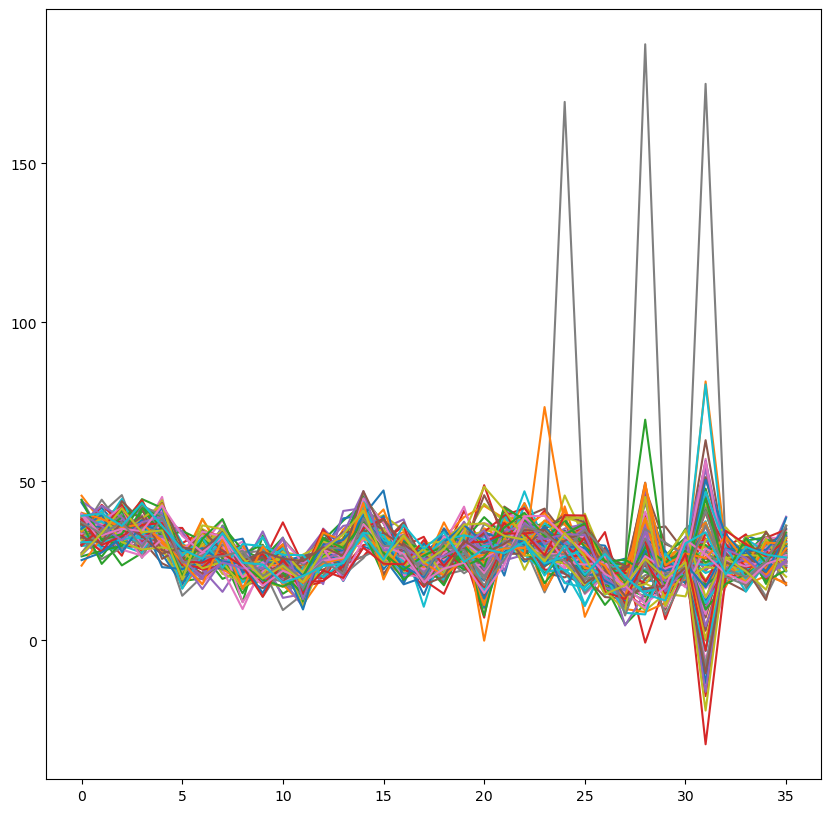

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for sample in sample_withseed:
    plt.plot(sample)
plt.show()

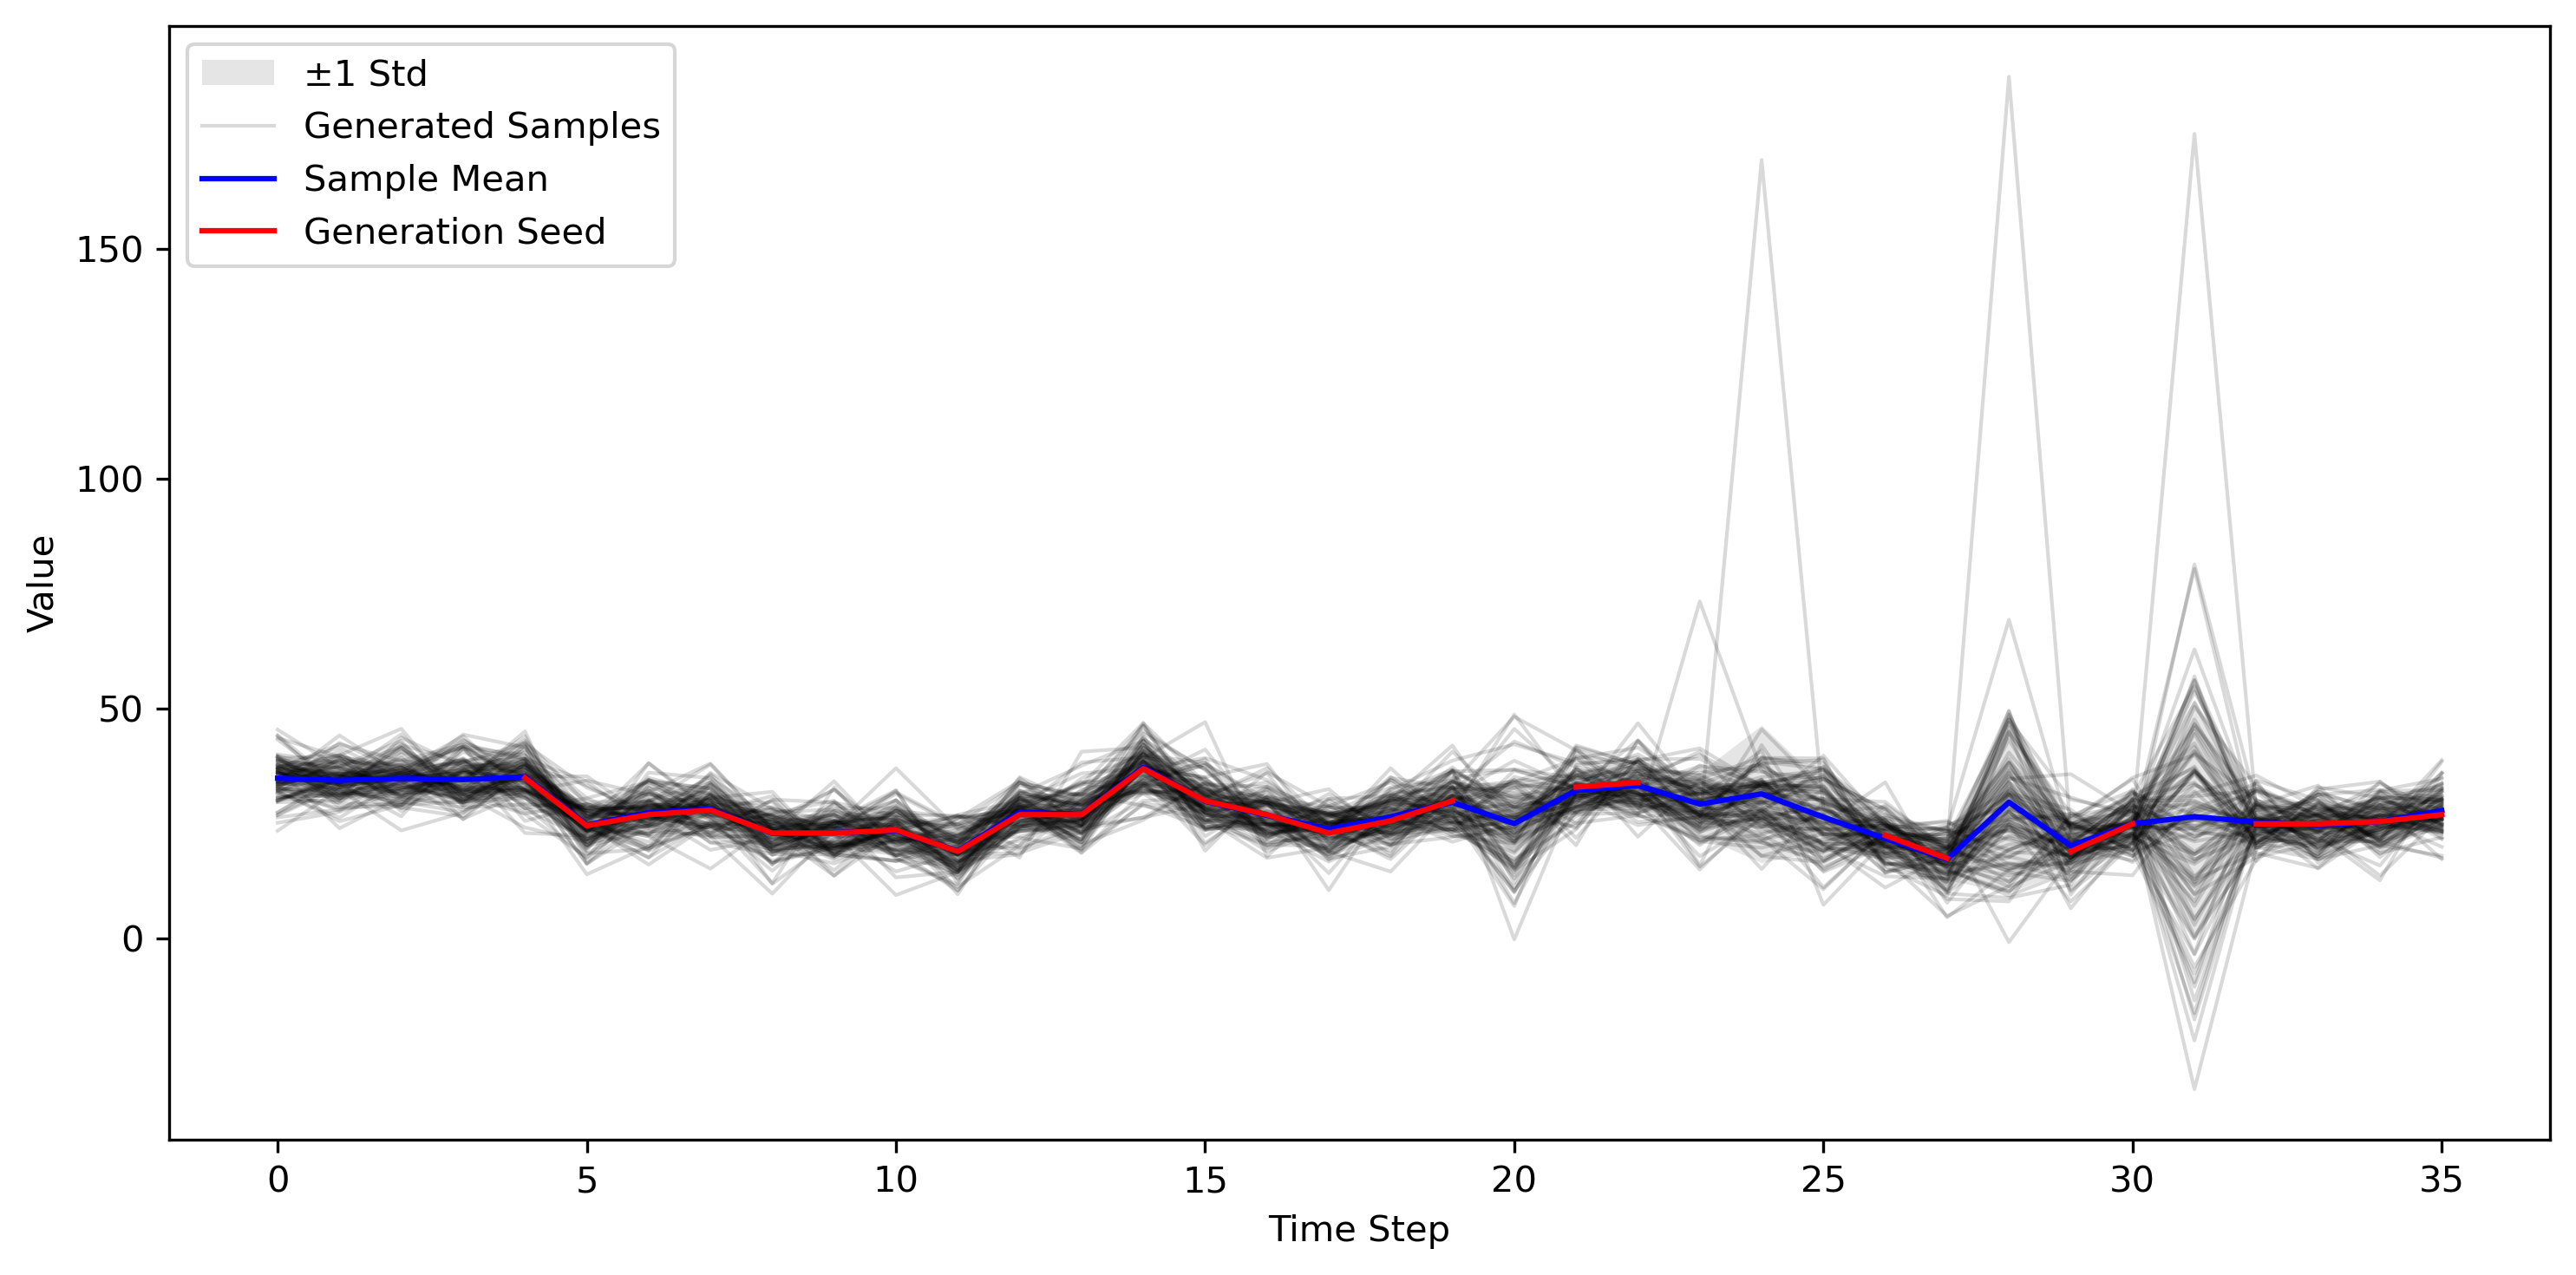

In [ ]:
from turtle import width
import numpy as np

mean_series = np.nanmean(sample_withseed, axis=0)
std_series = np.nanstd(sample_withseed, axis=0)

fig, ax = plt.subplots(figsize=(10, 5), dpi =300)

ax.fill_between(
    np.arange(sample_withseed.shape[1]),
    mean_series - 1*std_series,
    mean_series + 1*std_series,
    alpha=0.2,
    color="gray",
    label="±1 Std",
    linewidth=0
)

for idx, i in enumerate(sample_withseed):
    plt.plot(range(len(i)),i,color='black',alpha=0.15, linewidth=1,label = "Generated Samples" if idx == 0 else "")
    
plt.plot(mean_series, label="Sample Mean", linewidth=1.5, color="blue")
plt.plot(sample_seed, label="Generation Seed", linewidth=1.5, color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

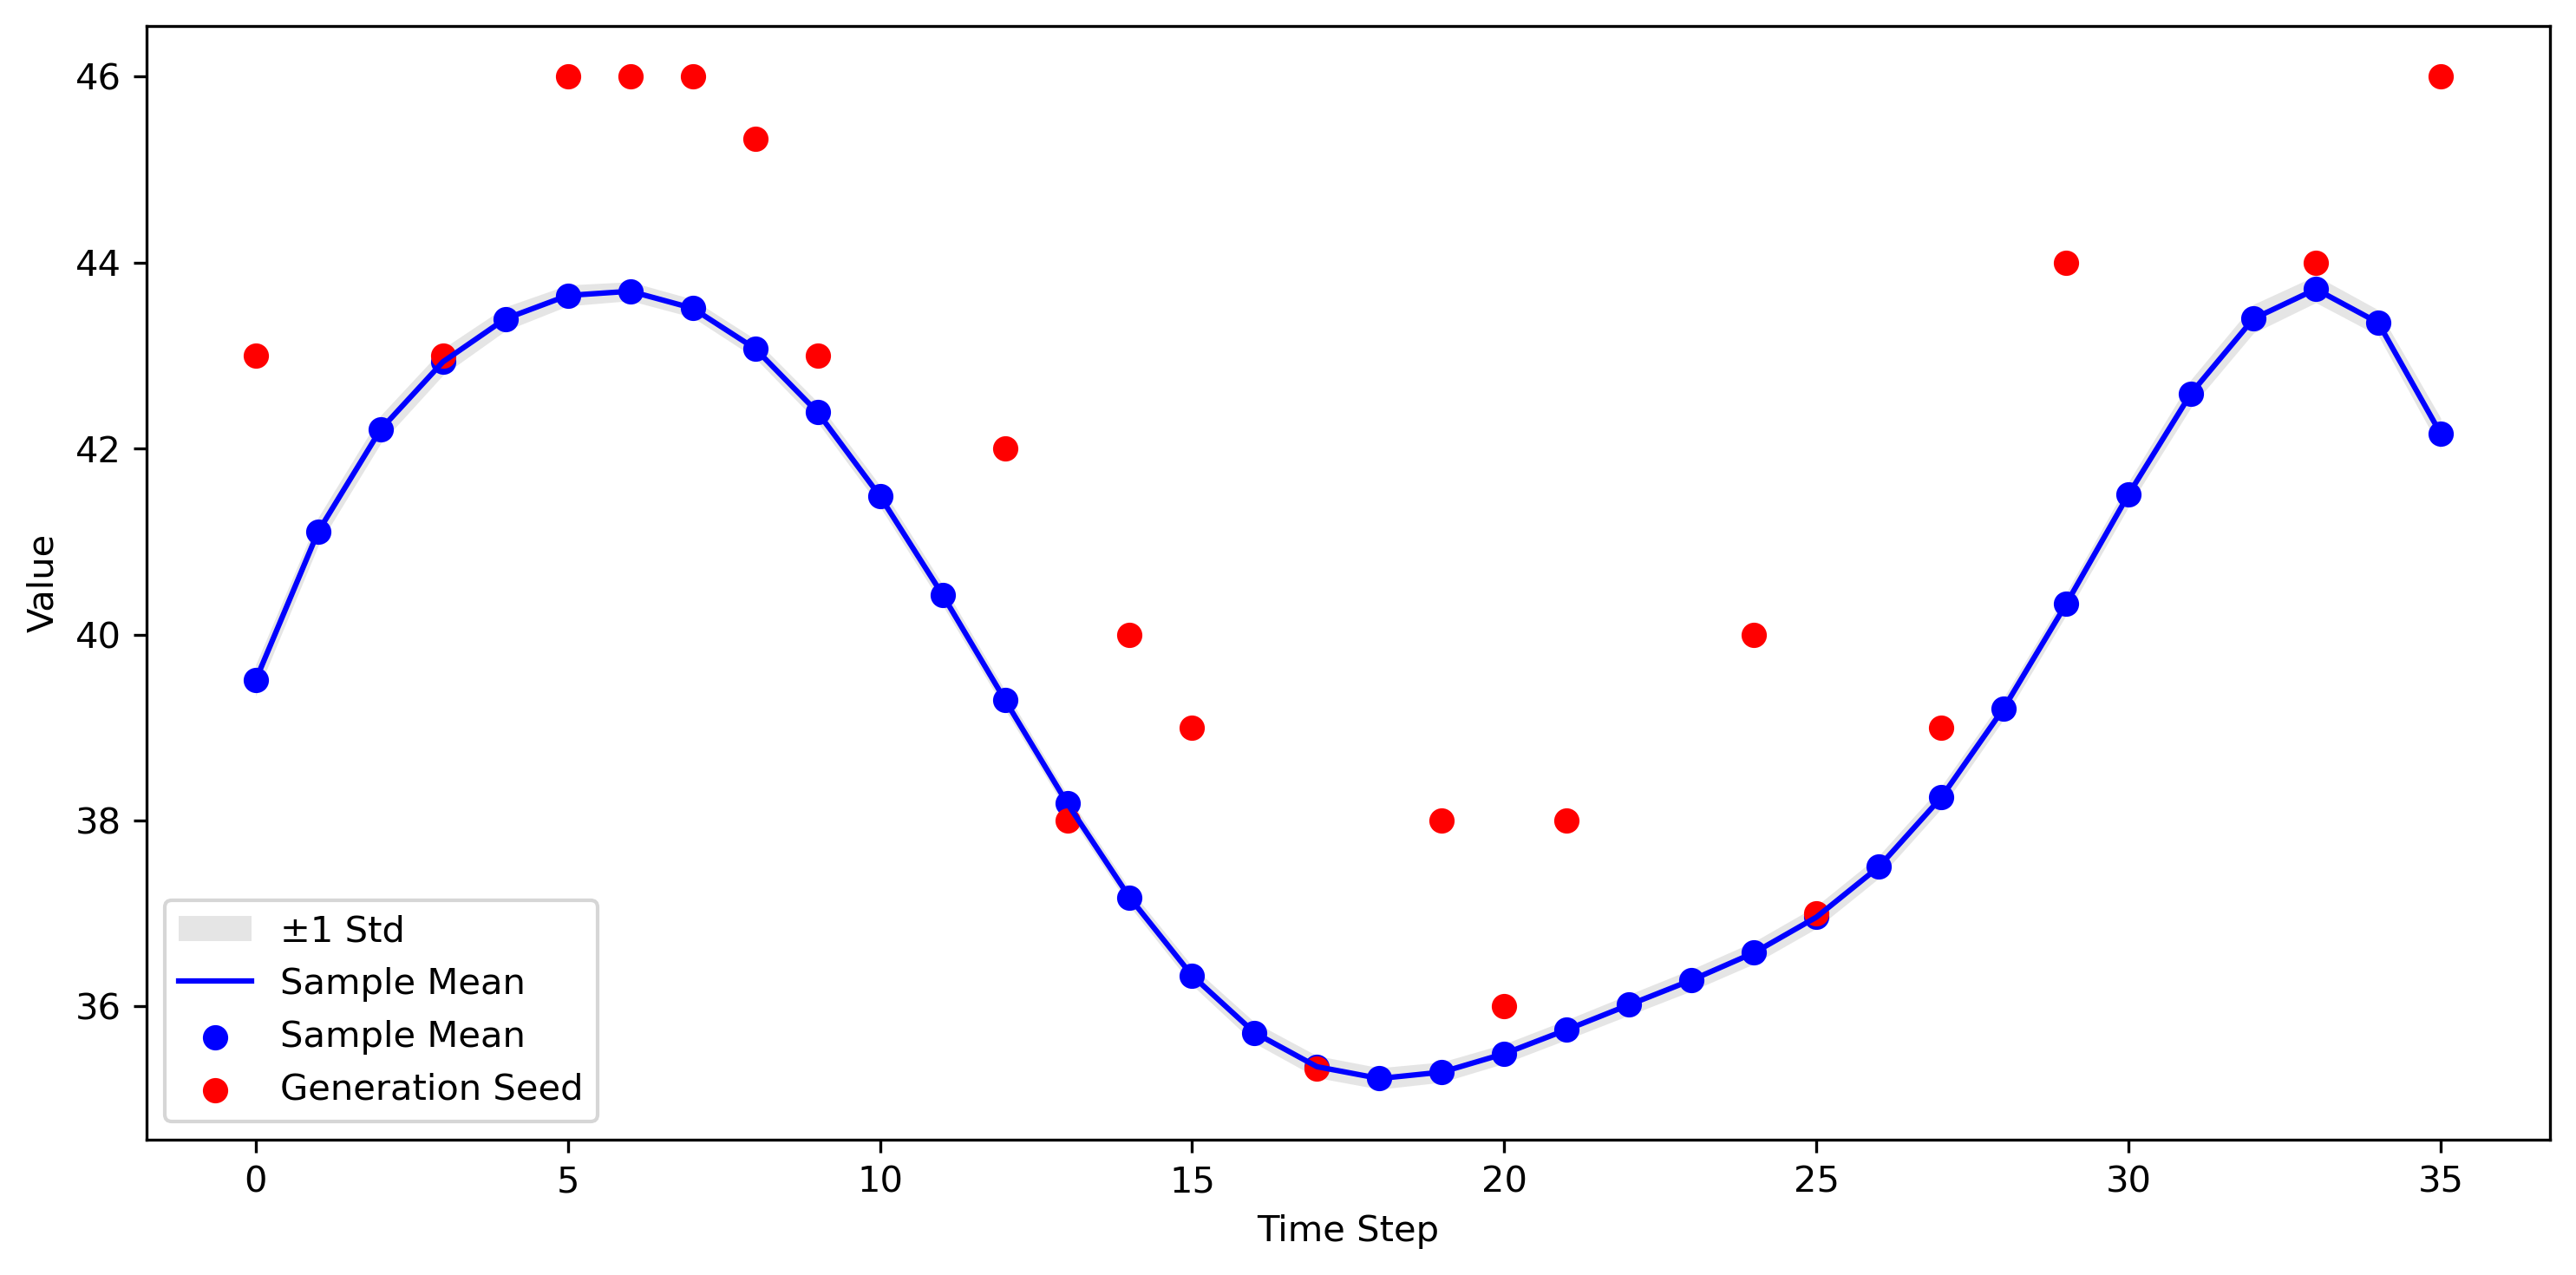

In [9]:
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample_withseed, axis=0)
std_series = np.nanstd(sample_withseed, axis=0)

fig, ax = plt.subplots(figsize=(10, 5), dpi =300)

ax.fill_between(
    np.arange(sample_withseed.shape[1]),
    mean_series - 1*std_series,
    mean_series + 1*std_series,
    alpha=0.2,
    color="gray",
    label="±1 Std",
    linewidth=0
)

# for idx, i in enumerate(sample_withseed):
#     plt.plot(range(len(i)),i,color='black',alpha=0.15, linewidth=1,label = "Generated Samples" if idx == 0 else "")
    
plt.plot(mean_series, label="Sample Mean", linewidth=1.5, color="blue")
plt.scatter(range(len(mean_series)),mean_series, label="Sample Mean", color="blue")

plt.scatter(range(len(sample_seed)),sample_seed, label="Generation Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

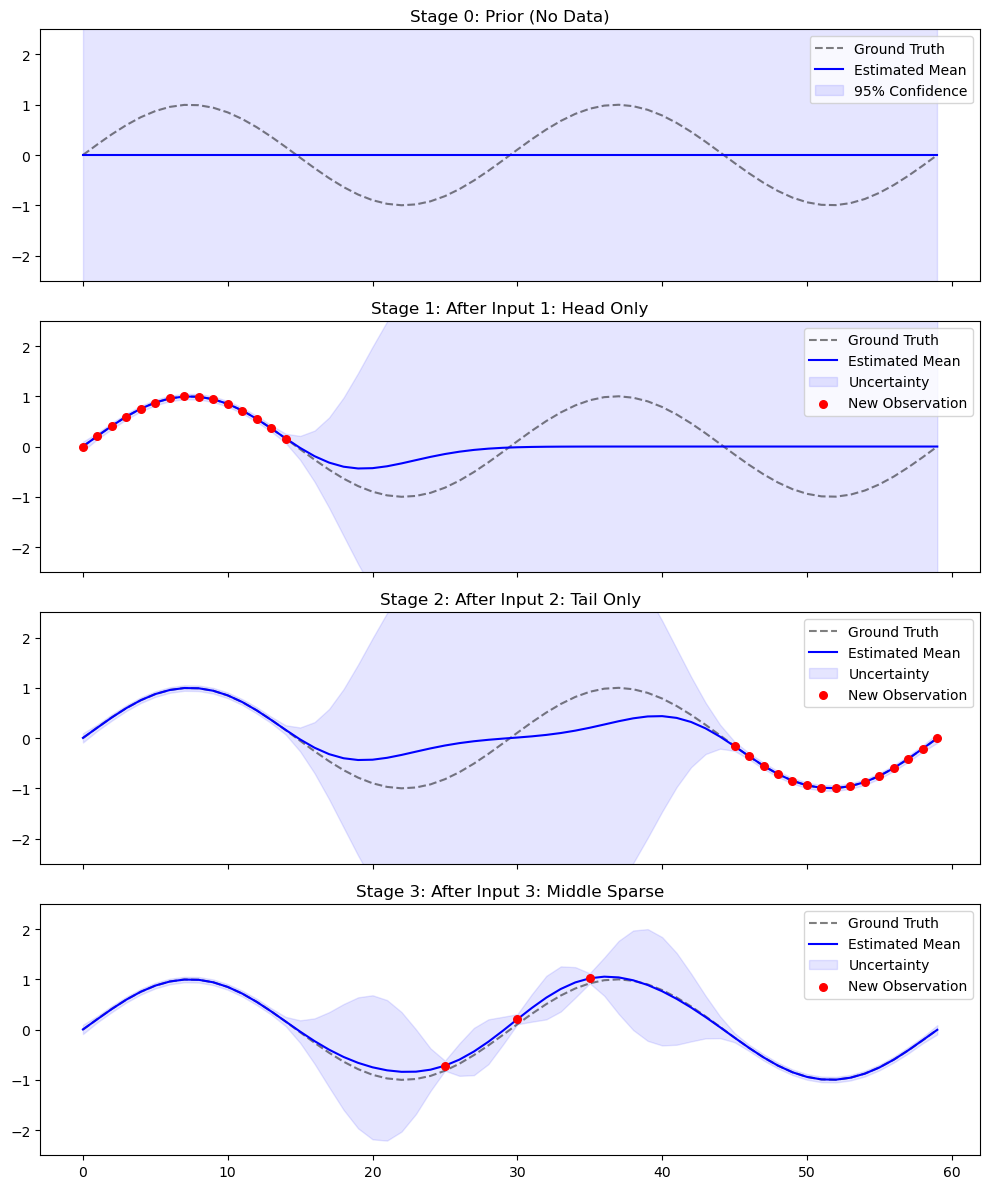

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 引入剛剛定義的 SequentialBayesianUpdater
# ==========================================
class SequentialBayesianUpdater:
    def __init__(self, n_timesteps, length_scale=10.0, sigma_f=1.0, sigma_noise=0.1):
        self.T = n_timesteps
        self.noise_var = sigma_noise**2
        self.mu = np.zeros(self.T)
        
        # 建立 RBF Kernel (相關性矩陣)
        x = np.arange(self.T).reshape(-1, 1)
        dists = x - x.T
        # length_scale 決定了「牽一髮動全身」的範圍
        self.Sigma = (sigma_f**2) * np.exp(-0.5 * (dists**2) / (length_scale**2))
        self.Sigma += np.eye(self.T) * 1e-6

    def update(self, fragment):
        fragment = np.asarray(fragment, float)
        mask_obs = np.isfinite(fragment)
        idx_obs = np.where(mask_obs)[0]
        
        if len(idx_obs) == 0: return

        y_obs = fragment[idx_obs]
        mu_obs = self.mu[idx_obs]
        Sigma_obs = self.Sigma[np.ix_(idx_obs, idx_obs)]
        Sigma_cross = self.Sigma[:, idx_obs]
        
        S = Sigma_obs + np.eye(len(idx_obs)) * self.noise_var
        try:
            K_gain = np.linalg.solve(S, Sigma_cross.T).T
        except np.linalg.LinAlgError:
            S += np.eye(len(idx_obs)) * 1e-4
            K_gain = np.linalg.solve(S, Sigma_cross.T).T

        innovation = y_obs - mu_obs
        self.mu = self.mu + K_gain @ innovation
        self.Sigma = self.Sigma - K_gain @ Sigma_cross.T

    def get_distribution(self):
        return self.mu, np.sqrt(np.diag(self.Sigma))

# ==========================================
# 2. 設定場景：正弦波修復任務
# ==========================================

# 總長度 60
T = 60
x_range = np.linspace(0, 4*np.pi, T)
ground_truth = np.sin(x_range) # 真實答案

# 初始化更新器
# length_scale=5.0 代表：如果我知道 t=10，那 t=5~15 的點都會被我強烈影響
updater = SequentialBayesianUpdater(n_timesteps=T, length_scale=5.0, sigma_f=2.0, sigma_noise=0.05)

# 準備三個破碎片段 (用 NaN 代表未知)
fragments = []

# 片段 1: 只有頭 (index 0~15)
f1 = np.full(T, np.nan)
f1[:15] = ground_truth[:15]
fragments.append(("Input 1: Head Only", f1))

# 片段 2: 只有尾 (index 45~60)
f2 = np.full(T, np.nan)
f2[45:] = ground_truth[45:]
fragments.append(("Input 2: Tail Only", f2))

# 片段 3: 中間稀疏的點 (隨機選 3 個點)
f3 = np.full(T, np.nan)
indices = [25, 30, 35]
f3[indices] = ground_truth[indices] + 0.1 # 加一點雜訊讓它真實一點
fragments.append(("Input 3: Middle Sparse", f3))

# ==========================================
# 3. 執行與繪圖
# ==========================================

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 階段 0: 什麼都還沒輸入 (Prior)
mu, std = updater.get_distribution()
ax = axes[0]
ax.plot(ground_truth, 'k--', alpha=0.5, label='Ground Truth')
ax.plot(mu, 'b-', label='Estimated Mean')
ax.fill_between(range(T), mu - 2*std, mu + 2*std, color='blue', alpha=0.1, label='95% Confidence')
ax.set_title("Stage 0: Prior (No Data)")
ax.legend(loc='upper right')
ax.set_ylim(-2.5, 2.5)

# 逐步輸入片段
for i, (name, frag) in enumerate(fragments):
    # === 關鍵步驟：更新分佈 ===
    updater.update(frag)
    # ========================
    
    mu, std = updater.get_distribution()
    
    ax = axes[i+1]
    # 畫出真實曲線
    ax.plot(ground_truth, 'k--', alpha=0.5, label='Ground Truth')
    # 畫出估計曲線
    ax.plot(mu, 'b-', label='Estimated Mean')
    # 畫出不確定性 (信心區間)
    ax.fill_between(range(T), mu - 2*std, mu + 2*std, color='blue', alpha=0.1, label='Uncertainty')
    
    # 畫出這次輸入的點
    mask = np.isfinite(frag)
    ax.scatter(np.where(mask)[0], frag[mask], c='red', s=30, zorder=5, label='New Observation')
    
    ax.set_title(f"Stage {i+1}: After {name}")
    ax.legend(loc='upper right')
    ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the generator with configuration parameters
generator_seed = tsg.Generator(
    window_size=cfg.WINDOW_SIZE,       # Length of each time series subsequence (default: 24)
    resolution=cfg.RESOLUTION,         # Time resolution of the data (default: '1h')
    seed=cfg.SEED,                     # Input seed sequence (default: sampled from N(mean=40, std=20, size=window_size))
    n_sample=cfg.NSAMPLE               # Number of new samples to generate (default: 500)
)

# Initialize the generator with configuration parameters
generator_seed2 = tsg.Generator(
    window_size=cfg.WINDOW_SIZE,       # Length of each time series subsequence (default: 24)
    resolution=cfg.RESOLUTION,         # Time resolution of the data (default: '1h')
    seed=cfg.SEED2,                     # Input seed sequence (default: sampled from N(mean=40, std=20, size=window_size))
    n_sample=cfg.NSAMPLE               # Number of new samples to generate (default: 500)
)

In [ ]:
# Generate samples from the estimated posterior distribution
sample_withseed = generator_seed.generate()
sample_withrandom = generator_seed2.generate()

### Visualization

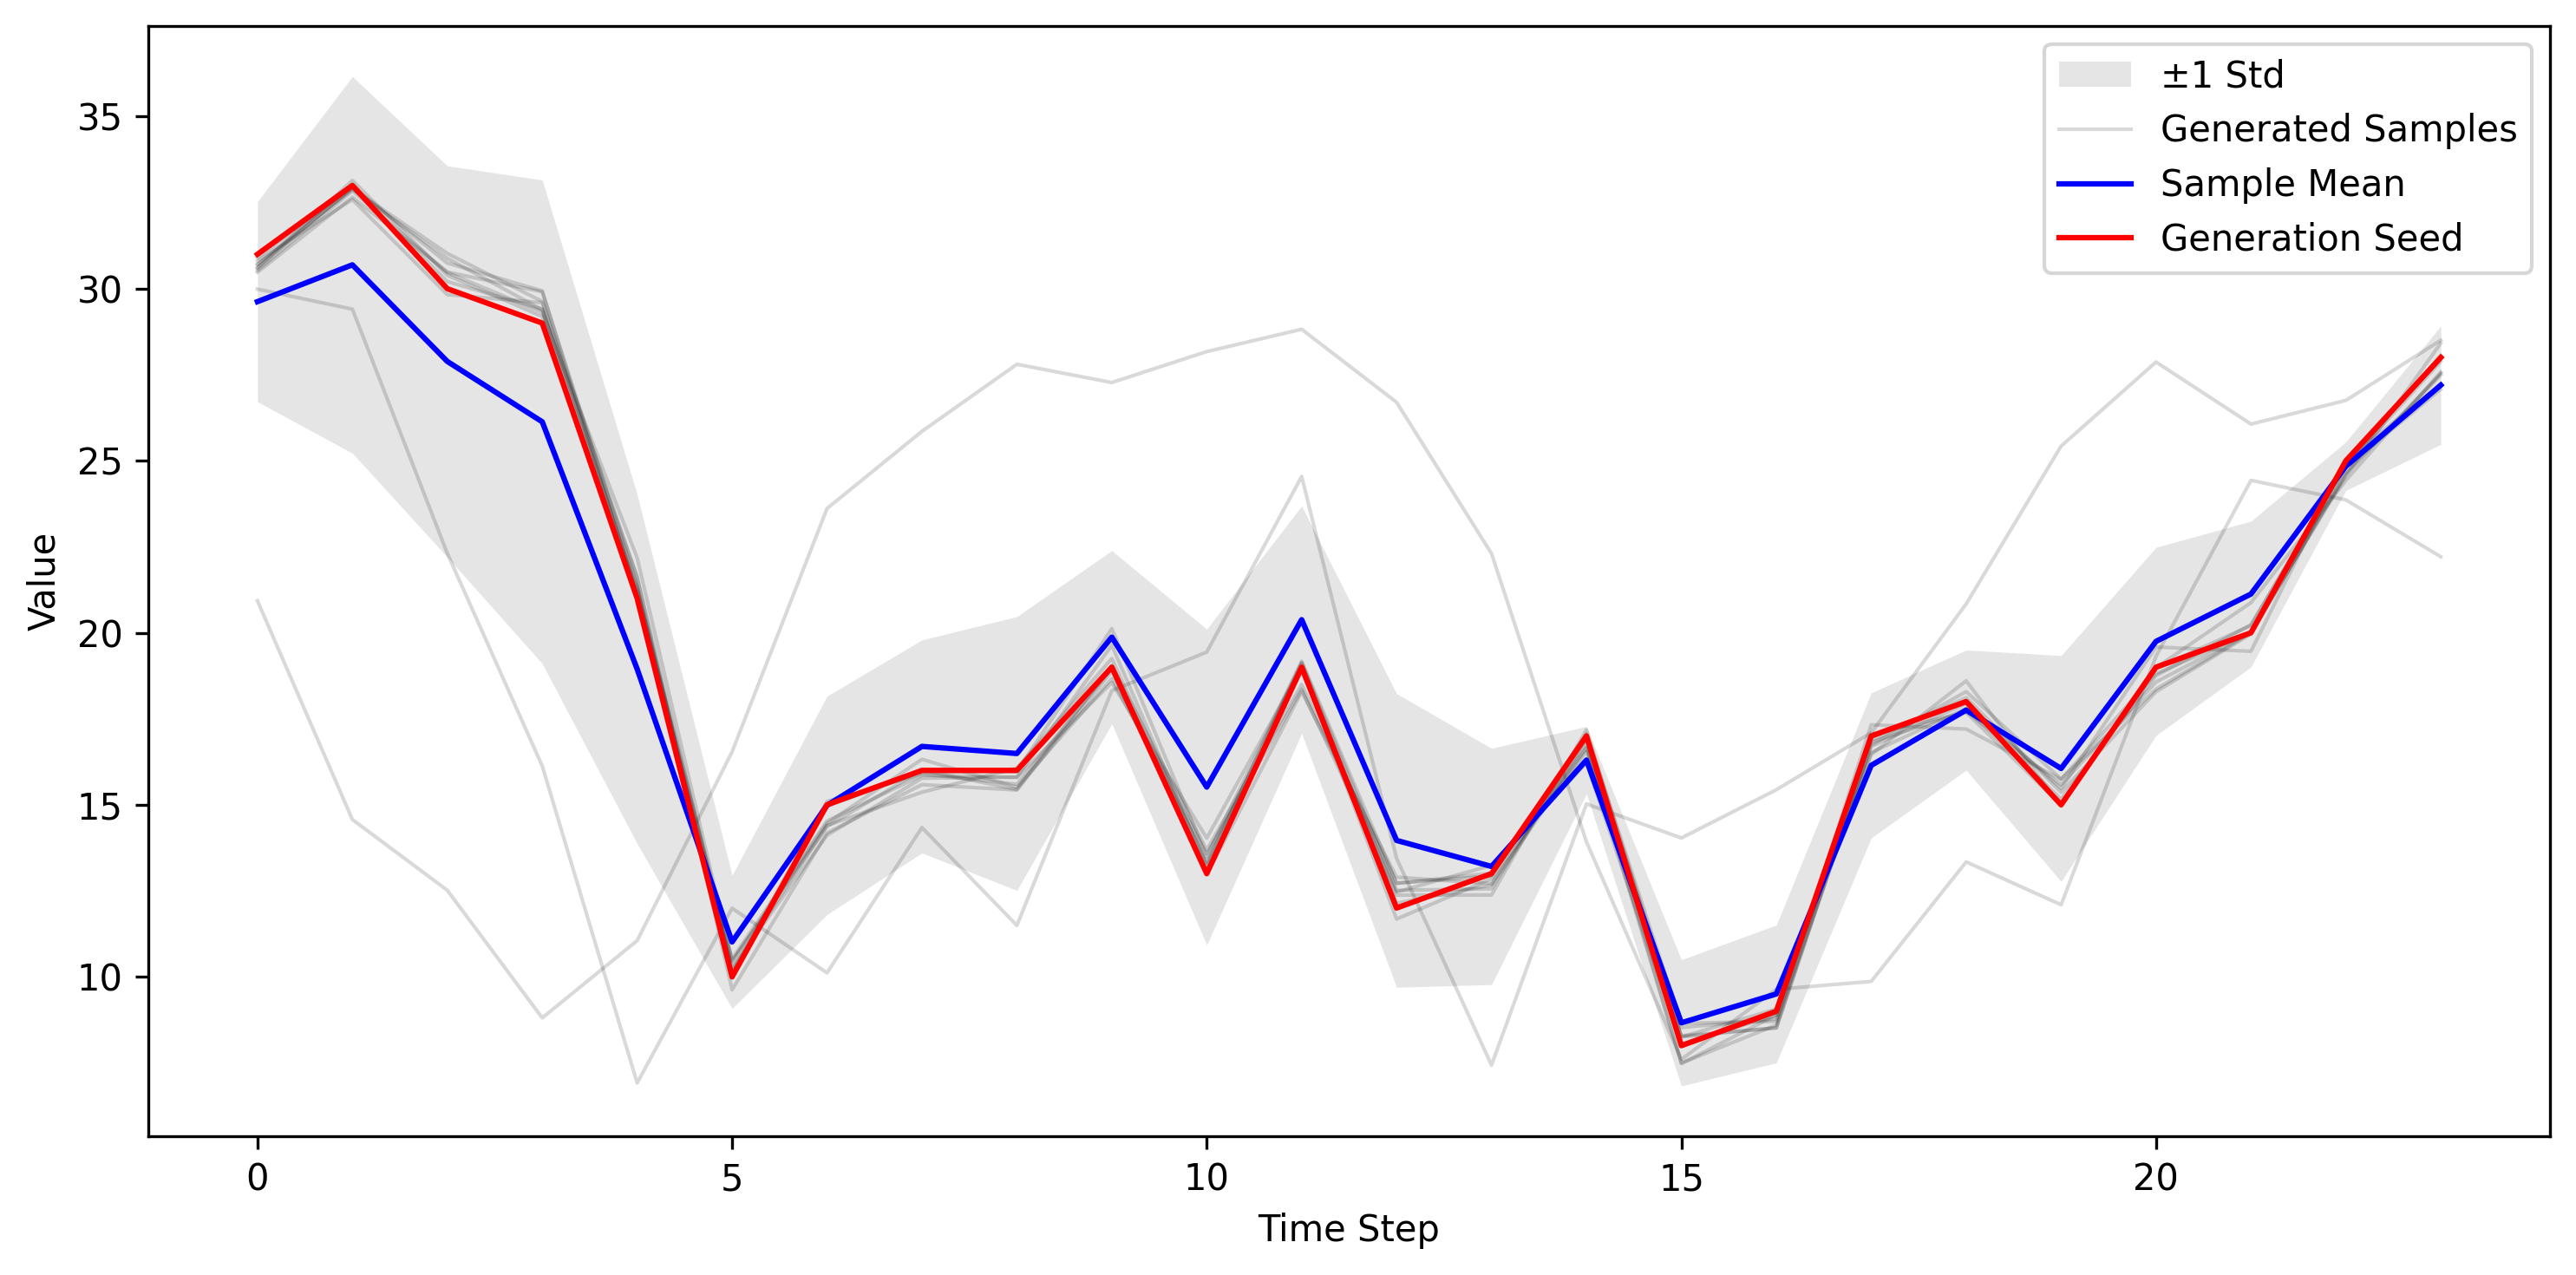

In [23]:
from turtle import width
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample_withseed, axis=0)
std_series = np.nanstd(sample_withseed, axis=0)

fig, ax = plt.subplots(figsize=(10, 5), dpi =300)

ax.fill_between(
    np.arange(sample_withseed.shape[1]),
    mean_series - 1*std_series,
    mean_series + 1*std_series,
    alpha=0.2,
    color="gray",
    label="±1 Std",
    linewidth=0
)

for idx, i in enumerate(sample_withseed):
    plt.plot(range(len(i)),i,color='black',alpha=0.15, linewidth=1,label = "Generated Samples" if idx == 0 else "")
    
plt.plot(mean_series, label="Sample Mean", linewidth=1.5, color="blue")
plt.plot(cfg.SEED, label="Generation Seed", linewidth=1.5, color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

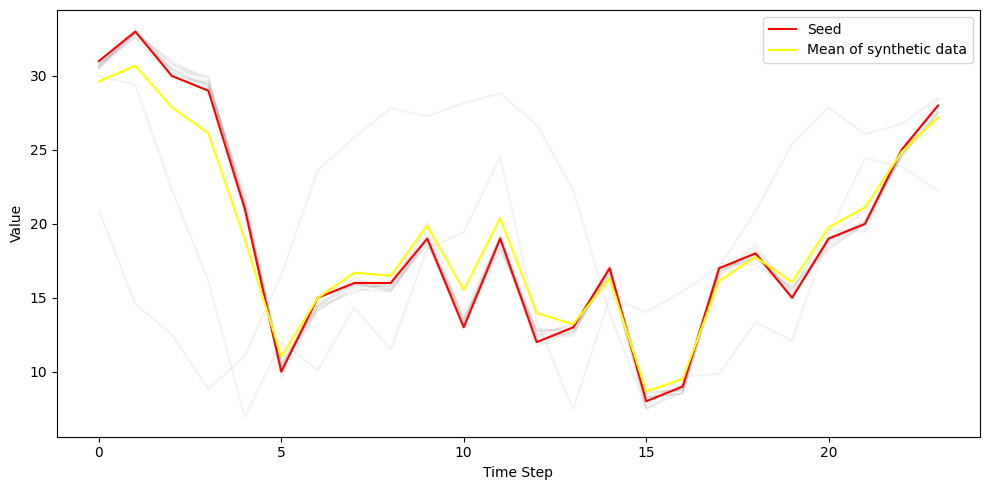

In [8]:
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample_withseed, axis=0)
std_series = np.nanstd(sample_withseed, axis=0)

plt.figure(figsize=(10, 5))
for i in sample_withseed:
    plt.plot(range(len(i)),i,color='black',alpha=0.05)

plt.plot(cfg.SEED, label="Seed", color="red")
plt.plot(mean_series, label="Mean of synthetic data", color="yellow")

# plt.plot(np.insert(cfg.SEED,0,[30,30,30,30]), label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

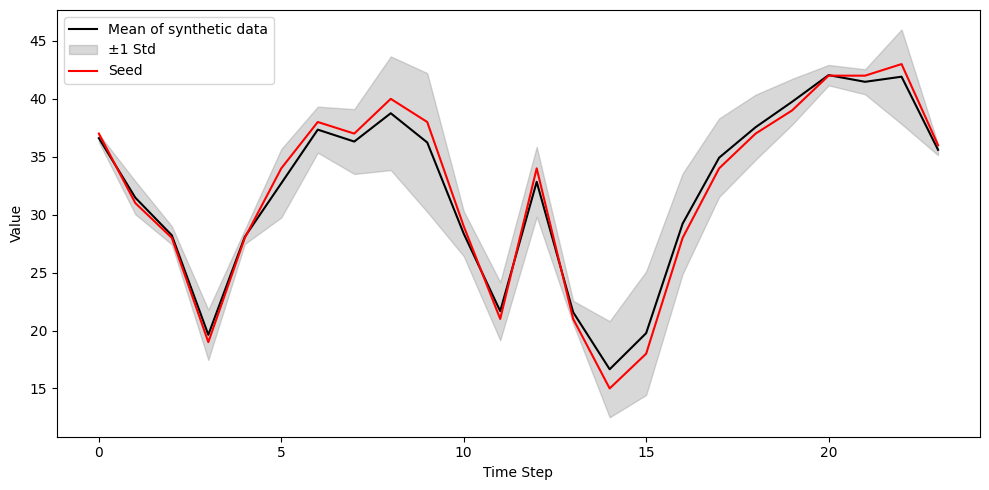

In [9]:
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample_withrandom, axis=0)
std_series = np.nanstd(sample_withrandom, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_series, label="Mean of synthetic data", color="black")
plt.fill_between(
    np.arange(sample_withrandom.shape[1]),
    mean_series - 1*std_series,
    mean_series + 1*std_series,
    alpha=0.3,
    color="gray",
    label="±1 Std"
)
plt.plot(cfg.SEED2, label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

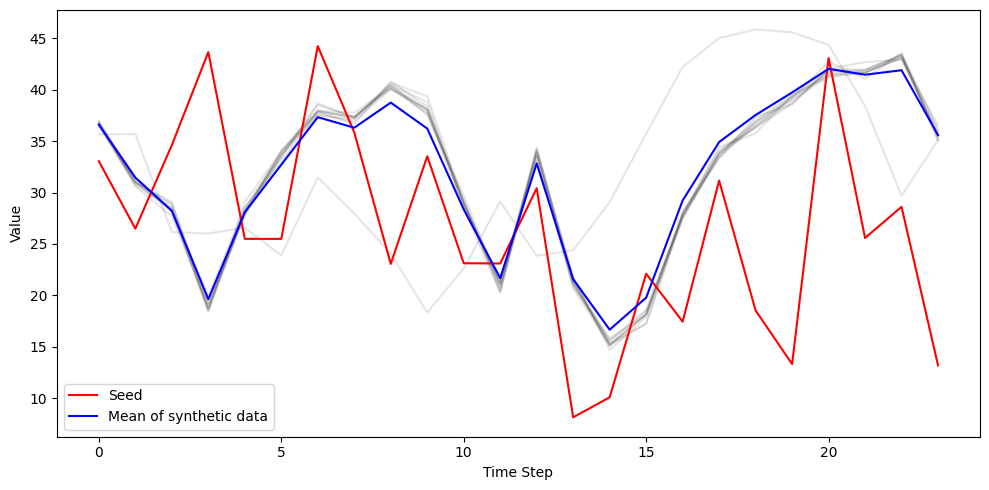

In [ ]:
from random import sample
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample_withrandom, axis=0)
std_series = np.nanstd(sample_withrandom, axis=0)

plt.figure(figsize=(10, 5))
for i in sample_withrandom:
    plt.plot(range(len(i)),i,color='black',alpha=0.1)

plt.plot(cfg.SEED2, label="Seed", color="red")
plt.plot(mean_series, label="Mean of synthetic data", color="blue")

# plt.plot(np.insert(cfg.SEED,0,[30,30,30,30]), label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

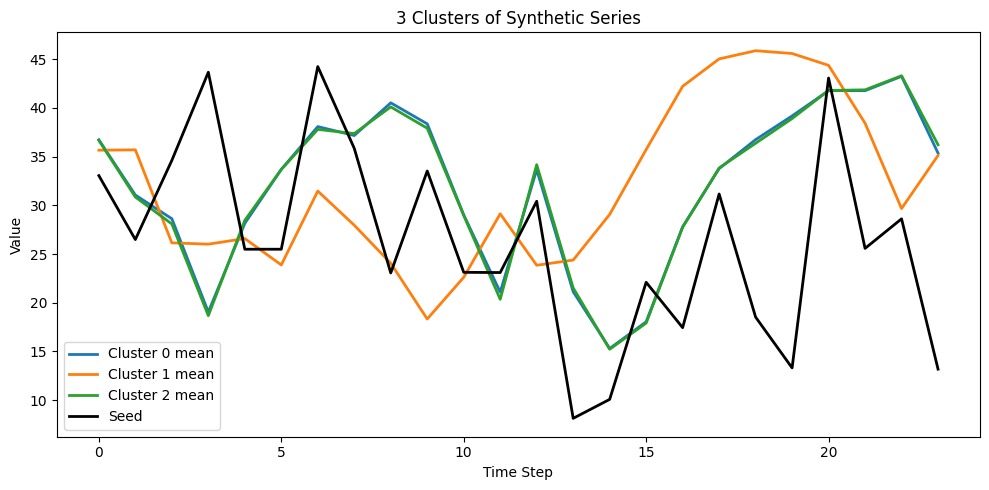

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# === choose your number of clusters ===
n_clusters = 3  # change this freely

# Flatten each time series into a feature vector (length = number of time steps)
X = np.array(sample_withrandom)

# === run KMeans ===
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# === visualize clusters ===
plt.figure(figsize=(10, 5))
for cluster_id in range(n_clusters):
    cluster_samples = X[labels == cluster_id]
    for series in cluster_samples:
        plt.plot(series, color=f"C{cluster_id}", alpha=0.005)
    plt.plot(np.mean(cluster_samples, axis=0), color=f"C{cluster_id}",
             label=f"Cluster {cluster_id} mean", linewidth=2)

plt.plot(sample_seed, color="black", label="Seed", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title(f"{n_clusters} Clusters of Synthetic Series")
plt.tight_layout()
plt.show()


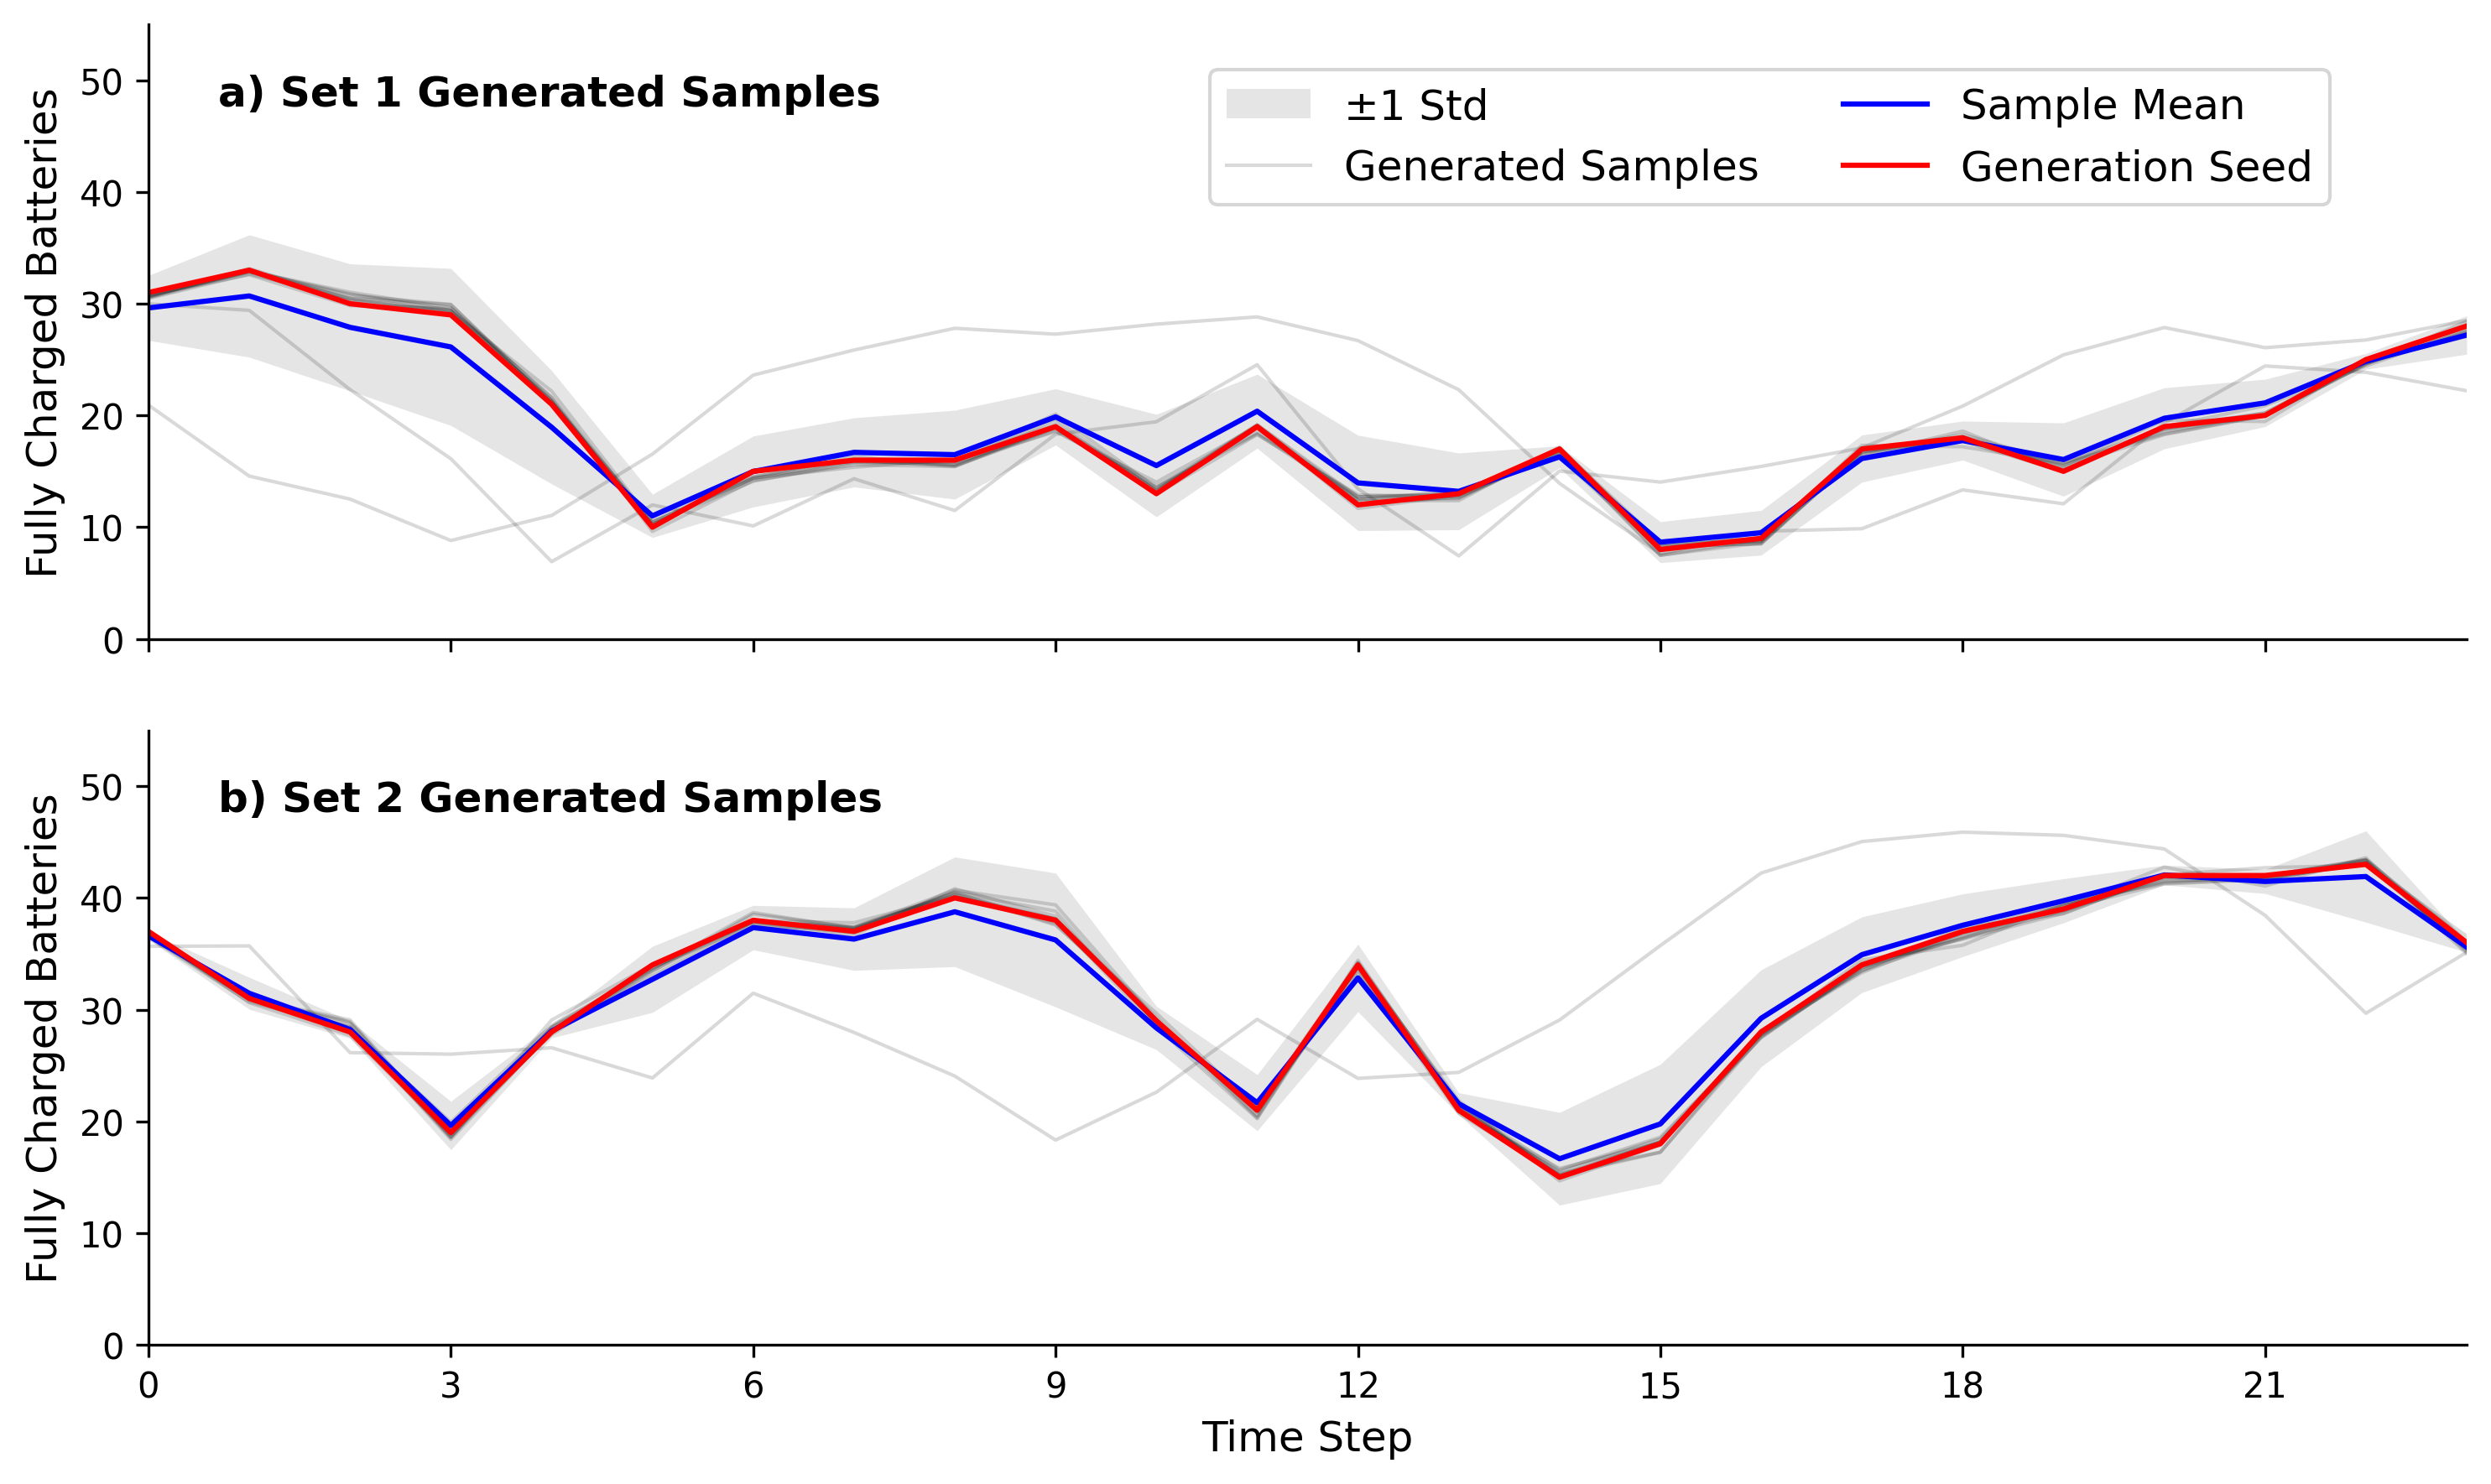

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# === First dataset ===
mean1 = np.nanmean(sample_withseed, axis=0)
std1 = np.nanstd(sample_withseed, axis=0)

# === Second dataset ===
mean2 = np.nanmean(sample_withrandom, axis=0)
std2 = np.nanstd(sample_withrandom, axis=0)

# === Plot ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), dpi=300, sharex=True)

# ---------- Top subplot ----------
ax = axes[0]
ax.fill_between(
    np.arange(sample_withseed.shape[1]),
    mean1 - std1,
    mean1 + std1,
    alpha=0.2,
    color="gray",
    label="±1 Std",
    linewidth=0
)
for idx, series in enumerate(sample_withseed):
    ax.plot(range(len(series)), series, color='black', alpha=0.15, linewidth=1,
            label="Generated Samples" if idx == 0 else "")
ax.plot(mean1, label="Sample Mean", linewidth=1.5, color="blue")
ax.plot(cfg.SEED, label="Generation Seed", linewidth=1.5, color="red")
ax.set_ylabel("Fully Charged Batteries", fontsize=12)
ax.text(0.03, 0.92, "a) Set 1 Generated Samples", transform=ax.transAxes, ha="left", va="top", fontsize=12, weight="bold")
ax.legend(ncol=2, loc = 'upper right', bbox_to_anchor=(0.95, 0.96), fontsize=12)

# ---------- Bottom subplot ----------
ax = axes[1]
ax.fill_between(
    np.arange(sample_withrandom.shape[1]),
    mean2 - std2,
    mean2 + std2,
    alpha=0.2,
    color="gray",
    label="±1 Std",
    linewidth=0
)
for idx, series in enumerate(sample_withrandom):
    ax.plot(range(len(series)), series, color='black', alpha=0.15, linewidth=1,
            label="Generated Samples" if idx == 0 else "")
ax.plot(mean2, label="Sample Mean", linewidth=1.5, color="blue")
ax.plot(cfg.SEED2, label="Generation Seed", linewidth=1.5, color="red")
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Fully Charged Batteries", fontsize=12)
ax.text(0.03, 0.92, "b) Set 2 Generated Samples", transform=ax.transAxes, ha="left", va="top", fontsize=12, weight = "bold")
# ax.legend()

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[0].set_ylim(0, 55)
axes[1].set_ylim(0, 55)

ax.set_xlim(0, cfg.WINDOW_SIZE - 1)
ax.set_xticks(np.arange(0, cfg.WINDOW_SIZE, step=cfg.WINDOW_SIZE // 8))
# ---------- Layout ----------
plt.tight_layout(h_pad=2.0)
plt.show()
